**Objective** : To identify creditworthy customers, help bank mitigate risk by predicting whether to approve credit for new customer or not.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from patsy import dmatrices
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
data=pd.read_csv('../input/Bankloans.csv')
data.head(3)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


## Separating Old & New Customer

In [5]:
#old customers for whom default data is available
old_cust=data[data['default'].notnull()]

In [6]:
old_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 699
Data columns (total 9 columns):
age         700 non-null int64
ed          700 non-null int64
employ      700 non-null int64
address     700 non-null int64
income      700 non-null int64
debtinc     700 non-null float64
creddebt    700 non-null float64
othdebt     700 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 54.7 KB


In [7]:
#new customer for whom default status is unknown
new_cust=data[data['default'].isnull()]

In [8]:
new_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 700 to 849
Data columns (total 9 columns):
age         150 non-null int64
ed          150 non-null int64
employ      150 non-null int64
address     150 non-null int64
income      150 non-null int64
debtinc     150 non-null float64
creddebt    150 non-null float64
othdebt     150 non-null float64
default     0 non-null float64
dtypes: float64(4), int64(5)
memory usage: 11.7 KB


## Pre-modelling UDFs

In [9]:
#udf for descriptive stats
def con_stats(x):
    return pd.Series({'Cnt':x.count(),'Sum':x.sum(),'NaNs':x.isnull().sum(),'%NaNs':((x.isnull().sum())/(x.count()))*100,'Uniques':x.value_counts().count(),
                      'Mean':x.mean(),'Std-Dev':x.std(),'Coef.Var':(x.std()/x.mean()),'Min':x.min(),'P1':x.quantile(0.01),'P5':x.quantile(0.05),
                      'P25':x.quantile(0.25),'P50':x.quantile(0.5),'P90':x.quantile(0.9),'P99':x.quantile(0.99),'Max':x.max()})

In [10]:
# outliers treatment
def outs(x):
    x.clip(lower=x.quantile(0.01),upper=x.quantile(0.99),inplace=True)
    return x

In [11]:
# dummy vars creator
def dum(x):
    x=pd.get_dummies(data=x,prefix='Dum',drop_first=True)
    return x

In [12]:
# descriptive stats of old customer
old_cust.apply(con_stats).T.round(2)

,Cnt,Sum,NaNs,%NaNs,Uniques,Mean,Std-Dev,Coef.Var,Min,P1,P5,P25,P50,P90,P99,Max
age,700.0,24402.00,0.0,0.0,37.0,34.86,8.00,0.23,20.00,21.00,23.00,29.00,34.00,46.00,53.01,56.00
ed,700.0,1206.00,0.0,0.0,5.0,1.72,0.93,0.54,1.00,1.00,1.00,1.00,1.00,3.00,4.00,5.00
employ,700.0,5872.00,0.0,0.0,32.0,8.39,6.66,0.79,0.00,0.00,0.00,3.00,7.00,18.00,27.01,31.00
address,700.0,5795.00,0.0,0.0,31.0,8.28,6.82,0.82,0.00,0.00,0.00,3.00,7.00,18.00,26.01,34.00
income,700.0,31921.00,0.0,0.0,114.0,45.60,36.81,0.81,14.00,15.00,17.00,24.00,34.00,82.00,190.30,446.00
debtinc,700.0,7182.40,0.0,0.0,231.0,10.26,6.83,0.67,0.40,0.90,1.90,5.00,8.60,19.61,30.70,41.30
creddebt,700.0,1087.49,0.0,0.0,695.0,1.55,2.12,1.36,0.01,0.03,0.11,0.37,0.85,3.62,9.89,20.56
othdebt,700.0,2140.75,0.0,0.0,699.0,3.06,3.29,1.07,0.05,0.16,0.38,1.04,1.99,7.04,17.18,27.03
default,700.0,183.00,0.0,0.0,2.0,0.26,0.44,1.68,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00


In [13]:
# stats of new customer
new_cust.apply(con_stats).T.round(2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,Cnt,Sum,NaNs,%NaNs,Uniques,Mean,Std-Dev,Coef.Var,Min,P1,P5,P25,P50,P90,P99,Max
age,150.0,5373.00,0.0,0.0,33.0,35.82,8.23,0.23,21.00,21.49,24.00,29.25,35.00,47.00,52.51,56.00
ed,150.0,248.00,0.0,0.0,4.0,1.65,0.93,0.56,1.00,1.00,1.00,1.00,1.00,3.00,4.00,4.00
employ,150.0,1409.00,0.0,0.0,29.0,9.39,7.28,0.77,0.00,0.00,0.00,4.00,8.00,19.00,31.53,33.00
address,150.0,1321.00,0.0,0.0,29.0,8.81,7.22,0.82,0.00,0.00,0.00,3.00,7.00,19.00,26.51,30.00
income,150.0,7753.00,0.0,0.0,73.0,51.69,45.56,0.88,13.00,14.00,16.00,25.25,39.00,98.00,260.12,324.00
debtinc,150.0,1463.50,0.0,0.0,111.0,9.76,6.20,0.64,0.10,0.95,1.54,5.40,8.90,17.01,32.35,32.50
creddebt,150.0,252.80,0.0,0.0,150.0,1.69,2.17,1.29,0.02,0.05,0.12,0.53,1.01,3.77,10.20,13.55
othdebt,150.0,476.22,0.0,0.0,150.0,3.17,3.89,1.22,0.05,0.18,0.27,1.09,2.11,7.20,15.45,35.20
default,0.0,0.00,150.0,inf,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# outlier treatment
old_cust.apply(outs)
new_cust.apply(outs)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:7412: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[mask] = np.nan


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36.0,1,16.0,13.00,32.0,10.9,0.544128,2.943872,NaN
701,50.0,1,6.0,26.51,21.0,12.9,1.316574,1.392426,NaN
702,40.0,1,9.0,9.00,33.0,17.0,4.880700,0.729300,NaN
703,31.0,1,5.0,7.00,23.0,2.0,0.046000,0.414000,NaN
704,29.0,1,4.0,0.00,24.0,7.8,0.866736,1.005264,NaN
...,...,...,...,...,...,...,...,...,...
845,34.0,1,12.0,15.00,32.0,2.7,0.239328,0.624672,NaN
846,32.0,2,12.0,11.00,116.0,5.7,4.026708,2.585292,NaN
847,48.0,1,13.0,11.00,38.0,10.8,0.722304,3.381696,NaN
848,35.0,2,1.0,11.00,24.0,7.8,0.417456,1.454544,NaN


In [15]:
old_cust.apply(con_stats).T.round(2)

,Cnt,Sum,NaNs,%NaNs,Uniques,Mean,Std-Dev,Coef.Var,Min,P1,P5,P25,P50,P90,P99,Max
age,700.0,24393.07,0.0,0.0,34.0,34.85,7.95,0.23,21.00,21.00,23.00,29.00,34.00,46.00,53.00,53.01
ed,700.0,1201.00,0.0,0.0,4.0,1.72,0.91,0.53,1.00,1.00,1.00,1.00,1.00,3.00,4.00,4.00
employ,700.0,5851.07,0.0,0.0,29.0,8.36,6.57,0.79,0.00,0.00,0.00,3.00,7.00,18.00,27.00,27.01
address,700.0,5771.07,0.0,0.0,28.0,8.24,6.72,0.82,0.00,0.00,0.00,3.00,7.00,18.00,26.00,26.01
income,700.0,31394.10,0.0,0.0,107.0,44.85,31.94,0.71,15.00,15.00,17.00,24.00,34.00,82.00,190.00,190.30
debtinc,700.0,7155.51,0.0,0.0,221.0,10.22,6.68,0.65,0.90,0.90,1.90,5.00,8.60,19.61,30.70,30.70
creddebt,700.0,1049.19,0.0,0.0,683.0,1.50,1.79,1.19,0.03,0.03,0.11,0.37,0.85,3.62,9.88,9.89
othdebt,700.0,2119.10,0.0,0.0,687.0,3.03,3.12,1.03,0.16,0.16,0.38,1.04,1.99,7.04,17.18,17.18
default,700.0,183.00,0.0,0.0,2.0,0.26,0.44,1.68,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00


In [16]:
new_cust.apply(con_stats).T.round(2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


,Cnt,Sum,NaNs,%NaNs,Uniques,Mean,Std-Dev,Coef.Var,Min,P1,P5,P25,P50,P90,P99,Max
age,150.0,5370.00,0.0,0.0,32.0,35.80,8.15,0.23,21.49,21.74,24.00,29.25,35.00,47.00,52.26,52.51
ed,150.0,248.00,0.0,0.0,4.0,1.65,0.93,0.56,1.00,1.00,1.00,1.00,1.00,3.00,4.00,4.00
employ,150.0,1406.06,0.0,0.0,29.0,9.37,7.22,0.77,0.00,0.00,0.00,4.00,8.00,19.00,30.78,31.53
address,150.0,1317.02,0.0,0.0,28.0,8.78,7.15,0.81,0.00,0.00,0.00,3.00,7.00,19.00,26.26,26.51
income,150.0,7684.24,0.0,0.0,71.0,51.23,43.04,0.84,14.00,14.00,16.00,25.25,39.00,98.00,257.12,260.12
debtinc,150.0,1464.20,0.0,0.0,109.0,9.76,6.18,0.63,0.95,0.97,1.54,5.40,8.90,17.01,32.33,32.35
creddebt,150.0,248.99,0.0,0.0,148.0,1.66,2.05,1.23,0.05,0.05,0.12,0.53,1.01,3.77,9.96,10.20
othdebt,150.0,456.44,0.0,0.0,148.0,3.04,3.03,1.00,0.18,0.19,0.27,1.09,2.11,7.20,15.37,15.45
default,0.0,0.00,150.0,inf,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Essential Assumptions Check

In [17]:
# checking for multi-collinearity
cormat=old_cust.corr()
cormat

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
age,1.000000,0.016576,0.537417,0.596973,0.521450,0.016926,0.308318,0.348911,-0.138654
ed,0.016576,1.000000,-0.158071,0.055560,0.225395,0.009992,0.103012,0.156523,0.118521
employ,0.537417,-0.158071,1.000000,0.324859,0.665369,-0.035332,0.405959,0.419337,-0.287197
address,0.596973,0.055560,0.324859,1.000000,0.345067,0.014967,0.215397,0.234896,-0.165389
income,0.521450,0.225395,0.665369,0.345067,1.000000,-0.022541,0.553114,0.626787,-0.099553
debtinc,0.016926,0.009992,-0.035332,0.014967,-0.022541,1.000000,0.534602,0.603630,0.388556
creddebt,0.308318,0.103012,0.405959,0.215397,0.553114,0.534602,1.000000,0.639984,0.238179
othdebt,0.348911,0.156523,0.419337,0.234896,0.626787,0.603630,0.639984,1.000000,0.138962
default,-0.138654,0.118521,-0.287197,-0.165389,-0.099553,0.388556,0.238179,0.138962,1.000000


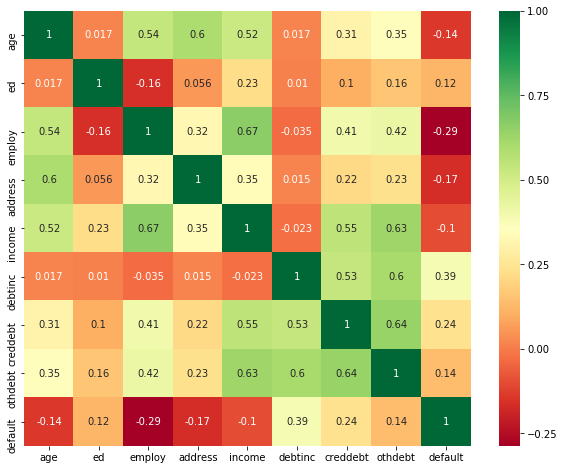

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(cormat,cmap='RdYlGn',annot=True)

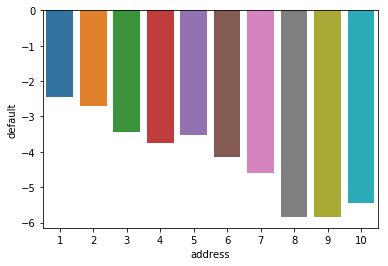

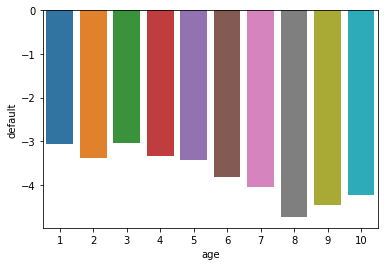

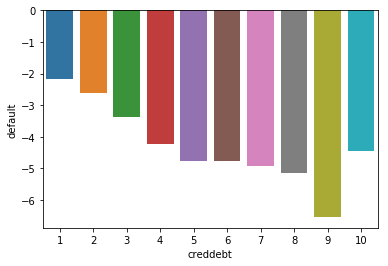

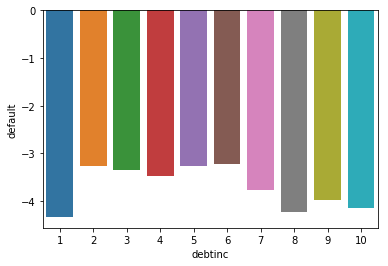

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


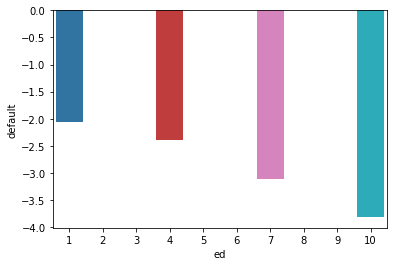

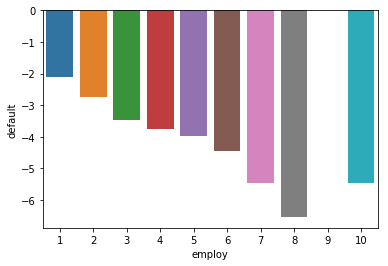

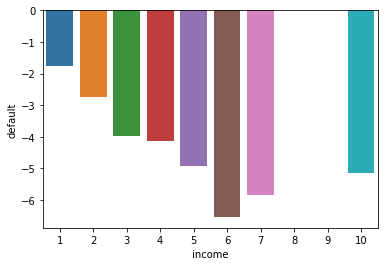

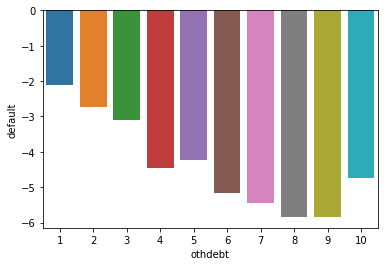

In [19]:
# Weight Of Evidence analysis, to check linearity of variables with target if any.

for var in old_cust.columns.difference(['default']):
    binned=pd.cut(old_cust[var],bins=10,labels=list(range(1,11)))
    odds=(old_cust.groupby(binned).default.sum())/(old_cust.default.count()-old_cust.groupby(binned).default.sum())
    log_odds=np.log(odds)
    sns.barplot(x=log_odds.index,y=log_odds)
    plt.show()

## Feature Engineering

In [20]:
#calculating Somer's D for each feature
feature=[]
somer=[]
for var in old_cust.columns.difference(['default']):
    f=('default~'+str(var))
    model=smf.logit(formula=f,data=old_cust).fit()
    y_score=np.array(model.predict())
    sd=2*metrics.roc_auc_score(old_cust['default'],y_score)-1
    feature.append(var)
    somer.append(sd)
    
somer_df=pd.DataFrame({'Features':feature,"Somers_D":somer})

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [21]:
somer_df.sort_values(by="Somers_D",ascending=False) #taking only those with SomersD greater than 0.2

,Features,Somers_D
3,debtinc,0.470506
5,employ,0.409138
2,creddebt,0.272378
0,address,0.222384
1,age,0.206329
6,income,0.200273
7,othdebt,0.173806
4,ed,0.148302


* variables - othdebt & ed have very low SomersD, hence their predictive power is low

In [22]:
# VIF check
vif=pd.DataFrame()
y,X=dmatrices('default~debtinc+employ+creddebt+address+age+income+othdebt+ed',data=old_cust,return_type='dataframe')
vif['Features']=X.columns
vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

In [23]:
vif.sort_values(by='VIF',ascending=False)  # most are within range, hence take all features for model building

,Features,VIF
0,Intercept,36.910987
6,income,5.121585
7,othdebt,4.562072
1,debtinc,3.910509
3,creddebt,2.628899
2,employ,2.401544
5,age,2.037593
4,address,1.561802
8,ed,1.287345


In [24]:
# removing variables with vif>4
vif2=pd.DataFrame()
y2,X2=dmatrices('default~debtinc+employ+creddebt+address+age+othdebt+ed',data=old_cust,return_type='dataframe')
vif2['Features']=X2.columns
vif2['VIF']=[variance_inflation_factor(X2.values,z) for z in range(X2.shape[1])]

In [25]:
vif2.sort_values(by='VIF',ascending=False)

,Features,VIF
0,Intercept,35.935809
6,othdebt,2.720089
1,debtinc,2.334000
2,employ,2.123688
3,creddebt,2.076815
5,age,1.995976
4,address,1.561693
7,ed,1.189361


In [26]:
# data split
train,test=train_test_split(old_cust,test_size=0.3,random_state=3994)

In [27]:
print(train.shape)
print(test.shape)

(490, 9)
(210, 9)


## Model Building

In [28]:
#using logistic regression
m1=smf.logit('default~debtinc+employ+creddebt+address+age+othdebt+ed',data=train).fit()

Optimization terminated successfully.
         Current function value: 0.419895
         Iterations 7


In [29]:
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.255     
Dependent Variable: default          AIC:              427.4972  
Date:               2019-10-23 17:28 BIC:              461.0524  
No. Observations:   490              Log-Likelihood:   -205.75   
Df Model:           7                LL-Null:          -276.09   
Df Residuals:       482              LLR p-value:      3.6488e-27
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.6899    0.7157  -2.3611  0.0182  -3.0927  -0.2871
debtinc        0.0635    0.0259   2.4468  0.0144   0.0126   0.1143
employ        -0.2387    0.0376  -6.3447  0.0000  -0.3125  -0.1650
creddebt       0.5891    0.108

In [30]:
#removing 'ed' it is insignificant and also had very low SomersD value
m2=smf.logit('default~debtinc+employ+creddebt+address+age+othdebt',data=train).fit()

Optimization terminated successfully.
         Current function value: 0.419916
         Iterations 7


In [31]:
print(m2.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.255     
Dependent Variable: default          AIC:              425.5173  
Date:               2019-10-23 17:28 BIC:              454.8782  
No. Observations:   490              Log-Likelihood:   -205.76   
Df Model:           6                LL-Null:          -276.09   
Df Residuals:       483              LLR p-value:      7.2475e-28
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.6415    0.6288  -2.6103  0.0090  -2.8740  -0.4090
debtinc        0.0626    0.0251   2.4888  0.0128   0.0133   0.1118
employ        -0.2403    0.0361  -6.6609  0.0000  -0.3110  -0.1696
creddebt       0.5913    0.107

In [32]:
#removing othdebt & age var, since it is insignificant and also had low SomersD value
m3=smf.logit('default~debtinc+employ+creddebt+address',data=train).fit()

Optimization terminated successfully.
         Current function value: 0.422571
         Iterations 7


In [33]:
print(m3.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.250     
Dependent Variable: default          AIC:              424.1199  
Date:               2019-10-23 17:28 BIC:              445.0919  
No. Observations:   490              Log-Likelihood:   -207.06   
Df Model:           4                LL-Null:          -276.09   
Df Residuals:       485              LLR p-value:      7.3279e-29
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.8875    0.2917  -3.0429  0.0023  -1.4592  -0.3159
debtinc        0.0690    0.0212   3.2488  0.0012   0.0274   0.1106
employ        -0.2182    0.0317  -6.8771  0.0000  -0.2804  -0.1560
creddebt       0.6004    0.104

In [34]:
#predicting for train & test data
train_predicted=m3.predict(train)
test_predicted=m3.predict(test)

## Model Evaluation

In [35]:
#calculating metrics
auc_train=metrics.roc_auc_score(train['default'],train_predicted)
auc_test=metrics.roc_auc_score(test['default'],test_predicted)
gini_train=2*auc_train-1
gini_test=2*auc_test-1

In [36]:
print('Train AUC :',auc_train,'||','Test AUC :',auc_test)
print('Train gini :',gini_train,'||','Test gini :',gini_test)

Train AUC : 0.8289138477215834 || Test AUC : 0.8983333333333334
Train gini : 0.6578276954431668 || Test gini : 0.7966666666666669


In [37]:
#predicting for train & test data
train_data=pd.DataFrame()
train_data['Actual']=train['default']
train_data['Pred_prob']=m3.predict(train)
test_data=pd.DataFrame()
test_data['Actual']=test['default']
test_data['Pred_prob']=m3.predict(test)

In [38]:
train_data

,Actual,Pred_prob
159,0.0,0.065324
364,1.0,0.462919
52,1.0,0.058949
181,0.0,0.053017
543,1.0,0.636070
...,...,...
190,1.0,0.405776
547,0.0,0.237968
201,1.0,0.065767
70,0.0,0.599458


In [39]:
test_data

,Actual,Pred_prob
599,1.0,0.970242
504,1.0,0.629934
368,0.0,0.190858
167,0.0,0.239493
655,0.0,0.015846
...,...,...
1,0.0,0.193765
391,1.0,0.263822
80,1.0,0.565726
393,1.0,0.856556


In [40]:
# calculating recalls, accuracy
se=[]
sp=[]
cu=[]
ac=[]

train_temp=train_data.copy()
for cutoff in np.linspace(0,1,150):
    train_temp['Cut-off']=cutoff
    train_temp['Predicted']=train_temp['Pred_prob'].apply(lambda x : 0.0 if x<cutoff else 1.0)
    train_temp['TP']=train_temp.apply(lambda x : 1.0 if x['Actual']==1.0 and x['Predicted']==1.0 else 0.0,axis=1)
    train_temp['FN']=train_temp.apply(lambda x : 1.0 if x['Actual']==1.0 and x['Predicted']==0.0 else 0.0,axis=1)
    train_temp['FP']=train_temp.apply(lambda x : 1.0 if x['Actual']==0.0 and x['Predicted']==1.0 else 0.0,axis=1)
    train_temp['TN']=train_temp.apply(lambda x : 1.0 if x['Actual']==0.0 and x['Predicted']==0.0 else 0.0,axis=1)
    sens=train_temp['TP'].sum()/(train_temp['TP'].sum()+train_temp['FN'].sum())
    spec=train_temp['TN'].sum()/(train_temp['TN'].sum()+train_temp['FP'].sum())
    accu=(train_temp['TP'].sum()+train_temp['TN'].sum())/(train_temp['TP'].sum()+train_temp['TN'].sum()+train_temp['FP'].sum()+train_temp['FN'].sum())
    se.append(sens)
    sp.append(spec)
    cu.append(cutoff)
    ac.append(accu)

metrics_df=pd.DataFrame({'Cutoff':np.array(cu),'Sensitivity':np.array(se),'Specificity':np.array(sp),'Accuracy':np.array(ac)})

In [41]:
metrics_df.reset_index(drop=True)

,Cutoff,Sensitivity,Specificity,Accuracy
0,0.000000,1.00000,0.000000,0.251020
1,0.006711,1.00000,0.057221,0.293878
2,0.013423,1.00000,0.111717,0.334694
3,0.020134,1.00000,0.158038,0.369388
4,0.026846,1.00000,0.177112,0.383673
...,...,...,...,...
145,0.973154,0.00813,1.000000,0.751020
146,0.979866,0.00000,1.000000,0.748980
147,0.986577,0.00000,1.000000,0.748980
148,0.993289,0.00000,1.000000,0.748980


In [42]:
# to find best cutoff, total should be max
metrics_df['Total']=metrics_df['Sensitivity']+metrics_df['Specificity']

In [43]:
metrics_df['Total'].max()

1.518375755964644

In [44]:
metrics_df[metrics_df['Total']==metrics_df['Total'].max()]

,Cutoff,Sensitivity,Specificity,Accuracy,Total
29,0.194631,0.878049,0.640327,0.7,1.518376


In [45]:
print(train_data.head(2))
print(test_data.head(2))

     Actual  Pred_prob
159     0.0   0.065324
364     1.0   0.462919
     Actual  Pred_prob
599     1.0   0.970242
504     1.0   0.629934


In [46]:
#taking cutoff probability as 0.195 & predicting defaults based on it
train_data['Predicted']=train_data['Pred_prob'].apply(lambda x:1 if x> 0.195 else 0)
test_data['Predicted']=test_data['Pred_prob'].apply(lambda x:1 if x> 0.195 else 0)

In [47]:
# confusion matrix for train
cm_train=pd.crosstab(train_data['Actual'],train_data['Predicted'],margins=False)
cm_test=pd.crosstab(test_data['Actual'],test_data['Predicted'],margins=False)

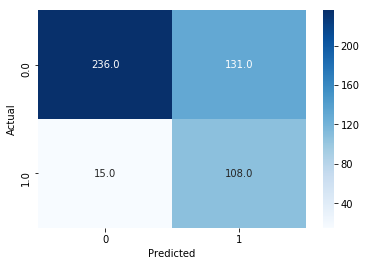

In [48]:
sns.heatmap(data=cm_train,annot=True,fmt='.1f',cmap='Blues')

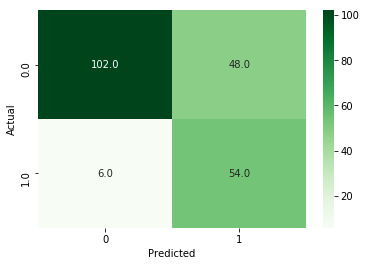

In [49]:
sns.heatmap(data=cm_test,annot=True,fmt='.1f',cmap='Greens')

In [50]:
#Overall Accuracy
train_ac=metrics.accuracy_score(train_data['Actual'],train_data['Predicted'])
test_ac=metrics.accuracy_score(test_data['Actual'],test_data['Predicted'])
print('Train Accu. :',train_ac,'||','Test Accu. :',test_ac)

Train Accu. : 0.7020408163265306 || Test Accu. : 0.7428571428571429


In [51]:
#other metrics
print('Training Data \n',metrics.classification_report(train_data['Actual'],train_data['Predicted']))
print('\nTesting Data\n',metrics.classification_report(test_data['Actual'],test_data['Predicted']))

Training Data 
               precision    recall  f1-score   support

         0.0       0.94      0.64      0.76       367
         1.0       0.45      0.88      0.60       123

    accuracy                           0.70       490
   macro avg       0.70      0.76      0.68       490
weighted avg       0.82      0.70      0.72       490


Testing Data
               precision    recall  f1-score   support

         0.0       0.94      0.68      0.79       150
         1.0       0.53      0.90      0.67        60

    accuracy                           0.74       210
   macro avg       0.74      0.79      0.73       210
weighted avg       0.83      0.74      0.76       210



In [52]:
# Decile Analysis
train_data['Deciles']=pd.qcut(train_data['Pred_prob'],10,labels=False)
train_data.head(10)

,Actual,Pred_prob,Predicted,Deciles
159,0.0,0.065324,0,2
364,1.0,0.462919,1,8
52,1.0,0.058949,0,2
181,0.0,0.053017,0,2
543,1.0,0.636070,1,9
141,1.0,0.430726,1,7
634,0.0,0.028728,0,1
576,1.0,0.129528,0,4
57,0.0,0.012474,0,0
55,1.0,0.697092,1,9


In [53]:
ones=train_data.groupby('Deciles').Actual.sum()
tot=train_data.groupby('Deciles').Actual.count()
min_prob=train_data.groupby('Deciles').Pred_prob.min()
max_prob=train_data.groupby('Deciles').Pred_prob.max()

In [54]:
dec_df=pd.DataFrame()
dec_df=pd.concat([min_prob,max_prob,ones,tot],axis=1)
dec_df.columns=['Min_prob','Max_prob','#1s','Total']

In [55]:
dec_df.sort_values(by='#1s',ascending=False)

,Min_prob,Max_prob,#1s,Total
Deciles,,,,
9,0.572821,0.979045,36.0,49
8,0.448973,0.571659,27.0,49
7,0.342296,0.448285,18.0,49
5,0.189515,0.254849,14.0,49
6,0.257037,0.339074,13.0,49
3,0.085643,0.125899,5.0,49
2,0.045322,0.082512,4.0,49
4,0.128914,0.187699,4.0,49
1,0.016407,0.045015,2.0,49


In [56]:
test_data['Deciles']=pd.qcut(test_data['Pred_prob'],10,labels=False)
ones2=test_data.groupby('Deciles').Actual.sum()
tot2=test_data.groupby('Deciles').Actual.count()
ma_p=test_data.groupby('Deciles').Pred_prob.max()
mi_p=test_data.groupby('Deciles').Pred_prob.min()

In [57]:
dec_df2=pd.DataFrame()
dec_df2=pd.concat([mi_p,ma_p,ones2,tot2],axis=1)
dec_df2.columns=['Min_prob','Max_prob','#1s','Total']

In [58]:
dec_df2.sort_values(by='#1s',ascending=False)

,Min_prob,Max_prob,#1s,Total
Deciles,,,,
9,0.684597,0.974016,19.0,21
8,0.497036,0.680802,15.0,21
6,0.249736,0.337007,11.0,21
7,0.341802,0.490774,7.0,21
4,0.147598,0.193639,3.0,21
2,0.041926,0.083182,2.0,21
5,0.193765,0.239493,2.0,21
3,0.084358,0.146246,1.0,21
0,0.001137,0.018512,0.0,21


## Predicting for New Customers

In [59]:
#prediction for new customers
new_cust.shape

(150, 9)

In [60]:
new_cust['Pred_prob']=m3.predict(new_cust)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
new_cust.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,Pred_prob
700,36.0,1,16.0,13.00,32.0,10.9,0.544128,2.943872,NaN,0.016368
701,50.0,1,6.0,26.51,21.0,12.9,1.316574,1.392426,NaN,0.105370
702,40.0,1,9.0,9.00,33.0,17.0,4.880700,0.729300,NaN,0.668311
703,31.0,1,5.0,7.00,23.0,2.0,0.046000,0.414000,NaN,0.096097
704,29.0,1,4.0,0.00,24.0,7.8,0.866736,1.005264,NaN,0.331367


In [62]:
new_cust['default']=new_cust['Pred_prob'].apply(lambda f : 1 if f>0.195 else 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
new_cust.head(10)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,Pred_prob
700,36.0,1,16.0,13.00,32.0,10.900,0.544128,2.943872,0,0.016368
701,50.0,1,6.0,26.51,21.0,12.900,1.316574,1.392426,0,0.105370
702,40.0,1,9.0,9.00,33.0,17.000,4.880700,0.729300,1,0.668311
703,31.0,1,5.0,7.00,23.0,2.000,0.046000,0.414000,0,0.096097
704,29.0,1,4.0,0.00,24.0,7.800,0.866736,1.005264,1,0.331367
705,25.0,2,1.0,3.00,14.0,9.900,0.232848,1.153152,1,0.385397
706,34.0,1,4.0,3.00,28.0,9.400,1.058064,1.573936,1,0.340655
707,50.0,1,30.0,8.00,150.0,32.351,10.200690,15.454814,1,0.606383
708,27.0,1,5.0,5.00,26.0,1.200,0.130416,0.184446,0,0.106836
709,31.0,4,7.0,12.00,97.0,6.000,1.827480,3.992520,0,0.162690


In [64]:
new_cust['default'].value_counts()

0    81
1    69
Name: default, dtype: int64

In [68]:
#credit worthy customers
pred_cred=new_cust[new_cust.default==0]
pred_cred.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,Pred_prob
700,36.0,1,16.0,13.00,32.0,10.9,0.544128,2.943872,0,0.016368
701,50.0,1,6.0,26.51,21.0,12.9,1.316574,1.392426,0,0.105370
703,31.0,1,5.0,7.00,23.0,2.0,0.046000,0.414000,0,0.096097
708,27.0,1,5.0,5.00,26.0,1.2,0.130416,0.184446,0,0.106836
709,31.0,4,7.0,12.00,97.0,6.0,1.827480,3.992520,0,0.162690


In [67]:
#customers predicted to default
pred_defaulters=new_cust[new_cust.default==1]
pred_defaulters.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,Pred_prob
702,40.0,1,9.0,9.0,33.0,17.000,4.880700,0.729300,1,0.668311
704,29.0,1,4.0,0.0,24.0,7.800,0.866736,1.005264,1,0.331367
705,25.0,2,1.0,3.0,14.0,9.900,0.232848,1.153152,1,0.385397
706,34.0,1,4.0,3.0,28.0,9.400,1.058064,1.573936,1,0.340655
707,50.0,1,30.0,8.0,150.0,32.351,10.200690,15.454814,1,0.606383


* From the 150 new customers for whom default status is unknown, our model predicts that :
    
    * 69 customers will default, hence credit may be refused to them to mitigate risk
    * 81 won't default, and bank shall proceed with approval of credit.